# **Book Summary vs. Book Cover:** Is it easier to predict a book genre based on the book summary or the book cover?

Author: Alyssa Hayo

Semester: Spring 2021

School: UMBC

Class: DATA606 - Capstone

I'm going to try two ways of using my data. Option 1 will be removing genres from the dataframe if the number of books in that genre is less than 500. Section 1.2.2 and 1.2.3 are the only difference in the code. I marked where the differences start and where the differences end. **While the results will differ, the code is entirely the same.**

I'm going to create a separate Jupyter Notebook for Option 2, where I do a more extensive genre mapping and upload the above dataframe (where each row only has one genre attached to it). This Notebook will be called "Capstone Project - Book Genres - Option 2". In Option 2 I will not replicate the work that is done for the CNNs.

In [1]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import json
import math

import os
import codecs
from argparse import ArgumentParser
from urllib import request
from tqdm import trange
from joblib import Parallel, delayed

import requests, zipfile, io
import tarfile
import csv
from tqdm import tqdm

## 1. Book Summary Data

### 1.1 Download the Data

In [2]:
download_url = "http://www.cs.cmu.edu/~dbamman/data/booksummaries.tar.gz"
r = requests.get(download_url)

tar_bytes = io.BytesIO(r.content)
tf = tarfile.open(mode = 'r', fileobj=tar_bytes)
tf.extractall()

In [3]:
#code adapted from: https://www.kaggle.com/iamhungundji/book-summary-genre-prediction/notebook

data = []

with open("booksummaries/booksummaries.txt", 'r', encoding="utf-8") as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)

16559it [00:00, 38166.20it/s]


In [4]:
#code adapted from: https://www.kaggle.com/iamhungundji/book-summary-genre-prediction/notebook
wiki_id = []
freebase_id = []
book_title = []
book_author = []
publication_date = []
genre = []
summary = []

for i in tqdm(data):
    wiki_id.append(i[0])
    freebase_id.append(i[1])
    book_title.append(i[2])
    book_author.append(i[3])
    publication_date.append(i[4])
    genre.append(i[5])
    summary.append(i[6])

books_summary = pd.DataFrame(data, columns = {'wiki_id': wiki_id, 'freebase_id': freebase_id, 
                      'book_title': book_title, 'book_author': book_author,
                      'publication_date': publication_date, 'genre': genre, 
                      'summary': summary})
books_summary.head()

100%|████████████████████████████████████████████████████████████████████| 16559/16559 [00:00<00:00, 1506027.71it/s]


wiki_id freebase_id                                 book_title  \
0     620     /m/0hhy                                Animal Farm   
1     843     /m/0k36                         A Clockwork Orange   
2     986     /m/0ldx                                 The Plague   
3    1756     /m/0sww  An Enquiry Concerning Human Understanding   
4    2080     /m/0wkt                       A Fire Upon the Deep   

       book_author publication_date  \
0    George Orwell       1945-08-17   
1  Anthony Burgess             1962   
2     Albert Camus             1947   
3       David Hume                    
4     Vernor Vinge                    

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
2  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
3                                                      
4  {"/m/03lrw": "Hard science fiction", "/m/06n90...   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...

In [5]:
books_summary.describe()

wiki_id freebase_id book_title book_author publication_date  genre  \
count      16559       16559      16559       16559            16559  16559   
unique     16559       16559      16277        4715             2640   2155   
top     24256116  /m/047r3h0    Nemesis                                       
freq           1           1          6        2382             5610   3718   

                                     summary  
count                                  16559  
unique                                 16532  
top      ~Plot outline description~ --> <!--  
freq                                      13

In [6]:
books_summary.shape

(16559, 7)

Data is downloaded! We have 7 columns and 16559 rows.

### 1.2 Clean the Data

#### 1.2.1 What do our genres look like?

In [7]:
print(books_summary['genre'].describe())
print()
print(books_summary['genre'].value_counts())

count     16559
unique     2155
top            
freq       3718
Name: genre, dtype: object

                                                                                                                                                         3718
{"/m/05hgj": "Novel"}                                                                                                                                     839
{"/m/06n90": "Science Fiction", "/m/014dfn": "Speculative fiction"}                                                                                       567
{"/m/06n90": "Science Fiction"}                                                                                                                           526
{"/m/02xlf": "Fiction"}                                                                                                                                   402
                                                                                                                      

Need to break the genres out into a readable list.

In [8]:
#next 3 blocks of code taken from https://www.kaggle.com/iamhungundji/book-summary-genre-prediction/notebook
books_summary.drop(books_summary[books_summary['genre']==''].index, inplace=True)
books_summary[books_summary['genre']=='']

Empty DataFrame
Columns: [wiki_id, freebase_id, book_title, book_author, publication_date, genre, summary]
Index: []

In [9]:
genres = []
for i in books_summary['genre']:
    genres.append(list(json.loads(i).values()))
books_summary['genre_new'] = genres

In [10]:
# How many genres are there?
all_genres = sum(genres,[])
len(set(all_genres))

227

In [11]:
books_summary.sample(5)

wiki_id freebase_id              book_title       book_author  \
13076  19902875  /m/04q6l1b           The Lucky One   Nicholas Sparks   
10888  13724892  /m/03cg9vx                  Saints  Orson Scott Card   
4436    3247527   /m/0912k5         Cryptid Hunters      Roland Smith   
6946    5854625   /m/0f95m9   The Professor's House      Willa Cather   
1237     542507   /m/02nb20  The Secret of Chimneys   Agatha Christie   

      publication_date                                              genre  \
13076          2008-09  {"/m/05hgj": "Novel", "/m/01qxvh": "Romance no...   
10888                   {"/m/03g3w": "History", "/m/06n90": "Science F...   
4436        2004-12-27                           {"/m/01hmnh": "Fantasy"}   
6946              1925                              {"/m/05hgj": "Novel"}   
1237                    {"/m/0lsxr": "Crime Fiction", "/m/02n4kr": "My...   

                                                 summary  \
13076   U.S. Marine Logan Thibault finds a photograph...   
10888   The book opens up in 1829 with the desertion ...   
4436    Marty and Grace O'Hara were very different tw...   
6946    When Professor Godfrey St. Peter and wife mov...   
1237    Seven years previously, the Balkan state of H...   

                                          genre_new  
13076                        [Novel, Romance novel]  
10888  [History, Science Fiction, Fantasy, Fiction]  
4436                                      [Fantasy]  
6946                                        [Novel]  
1237    [Crime Fiction, Mystery, Fiction, Suspense]

#### 1.2.2 Get the count of each genre

In [12]:
# Create a list of all of the genres
genre_list = []

for i, row in books_summary.iterrows():
  genres = row['genre_new']
  for item in range(len(genres)):
    genre_list.append(genres[item])

In [13]:
# Grabbed code from: https://www.geeksforgeeks.org/counting-the-frequencies-in-a-list-using-dictionary-in-python/

def CountFrequency(my_list):
  # Create an empty dictionary
  freq = {}
  for item in my_list:
    if (item in freq):
      freq[item] += 1
    else:
      freq[item] = 1

  return freq

In [14]:
genre_count = CountFrequency(genre_list)

In [15]:
# View the genre and their count
for key,value in genre_count.items():
    print(key,value)

Roman à clef 29
Satire 123
Children's literature 2122
Speculative fiction 4314
Fiction 4747
Science Fiction 2870
Novella 87
Utopian and dystopian fiction 67
Existentialism 8
Absurdist fiction 29
Novel 2463
Hard science fiction 25
Fantasy 2413
War novel 87
Bildungsroman 42
Religious text 4
Picaresque novel 18
Gothic fiction 112
Horror 511
Invasion literature 4
Mystery 1396
Epistolary novel 30
Parody 15
Psychological novel 26
Farce 4
Philosophy 47
Science 22
Dystopia 127
Detective fiction 341
Suspense 765
Historical fiction 388
Adventure novel 330
Humour 62
Historical novel 654
Sea story 4
Cyberpunk 16
Business 16
Non-fiction 230
Economics 13
Anthropology 4
Sociology 31
Romance novel 435
Poetry 28
Chivalric romance 15
High fantasy 66
Time travel 20
Scientific romance 14
Crime Fiction 753
Juvenile fantasy 2
Religion 16
Inspirational 10
Short story 78
Techno-thriller 59
Thriller 568
Young adult literature 825
Drama 29
Play 9
Albino bias 2
Computer Science 1
Reference 38
Supernatural 4
Come

In [16]:
# How many genres are there? - Confirm it is still the same as earlier, it should be 227.
print(len(genre_count))

227


For each genre for the book, create a new row with only one genre.

In [17]:
# Create a blank dataframe to append the new rows to
blank_df = pd.DataFrame(columns=['wiki_id','freebase_id','book_title','book_author','publication_date','genre_new','summary'])

# If there are multiple genres, make a new row for each genre
for i, row in books_summary.iterrows():
  genres = row['genre_new']
  for x in range(len(genres)):
    genre_name = genres[x]
    new_row = [row['wiki_id'],row['freebase_id'],row['book_title'],row['book_author'],row['publication_date'],genre_name, row['summary']]
    new_df = pd.DataFrame([new_row], columns=['wiki_id','freebase_id','book_title','book_author','publication_date','genre_new','summary'])
    blank_df = blank_df.append(new_df)

In [18]:
blank_df.sample(5)

wiki_id freebase_id                     book_title         book_author  \
0  28323095  /m/0fq0crs  The Dragonslayer's Apprentice                       
0  15328146  /m/03m53xv                The Brave Bulls  Thomas C. Lea, III   
0  15015546  /m/03h4pfy      The Seven Songs of Merlin        T. A. Barron   
0   4838590   /m/0cqbj6           The Teutonic Knights  Henryk Sienkiewicz   
0    786078   /m/03c5xt                 Zuleika Dobson        Max Beerbohm   

  publication_date            genre_new  \
0                               Fantasy   
0       1949-04-20              Western   
0             1997  Speculative fiction   
0                                 Novel   
0             1911                Novel   

                                             summary  
0   The novel is written primarily about a girl c...  
0   The Brave Bulls is the story of Luis Bello, "...  
0   Young Merlin has brought new hope to Fincayra...  
0   Krzyżacy tells the story of a young nobleman,...  
0   Zuleika Dobson is a stunningly attractive you...

**This is where Option 1 and Option 2 start to differ.**

I'm going to **export** the above dataframe (blank_df) as a CSV and do my genre mappings in Excel. As noted above, the dataframe above only has one genre per row. I'm going to need to map 227 genres to 7 genres, so instead of trying to code that out, I'm just going to do that work in Excel because it will be easier.

In section 1.2.3, I am going to **upload** that genre mapping file back into the notebook.

In [19]:
blank_df.shape

(30004, 7)

Only need to run the below code once, so I'm moving it to a "text box" because it doesn't ened to be run again



```
# only need to do this once - do not need to do this in local runtime
from google.colab import drive
drive.mount('/drive')

blank_df.to_csv('/drive/My Drive/old_genre.csv')
```



#### 1.2.3 Genre mapping 

I'm going to now condense the remaining 13 genres to 7 genres to match the amount of genres I'll be using for my book covers data.

In [82]:
# note this is done on local runtime.
df = pd.read_csv(r'C:\\Users\\Ethan\\Documents\\Alyssa\\book_summary_genres.csv', encoding="ISO-8859-1")

In [26]:
df.shape

(30004, 57)

Same amount of rows, the only difference is that there are some "Unamed" columns that were pulled in through excel. This is the same data! Just with our new genre mapping. The new genre that I will be using is called "genre".

What are the genre mappings?

In [83]:
df_mapping = df[['genre_new', 'genre']]
df_mapping.sample(3)

genre_new            genre
2308   Children's literature       Children's
22406        Science Fiction  Science Fiction
23399    Speculative fiction          Fantasy

In [87]:
unique_genres = df_mapping.genre.unique()
unique_genres

array(['Literary Fiction', 'Mystery', 'Science Fiction', 'Non-Fiction',
       'Other', 'Fantasy', "Children's"], dtype=object)

In [97]:
df_mapping.groupby(['genre'])['genre_new'].unique()

genre
Children's          [Boys' school stories, Children's literature, ...
Fantasy             [Bangsian fantasy, Cabal, Comic fantasy, Conte...
Literary Fiction    [Absurdist fiction, Adventure, Adventure novel...
Mystery             [Albino bias, Crime Fiction, Detective fiction...
Non-Fiction         [Alternate history, Anthropology, Autobiograph...
Other               [Anthology, Black comedy, Chick lit, Chivalric...
Science Fiction     [Alien invasion, Apocalyptic and post-apocalyp...
Name: genre_new, dtype: object

In [96]:
for list in df_mapping.groupby(['genre'])['genre_new'].unique():
  print(list)

["Boys' school stories" "Children's literature"
 'English public-school stories']
['Bangsian fantasy' 'Cabal' 'Comic fantasy' 'Contemporary fantasy'
 'Dark fantasy' 'Fable' 'Fairy tale' 'Fairytale fantasy' 'Fantastique'
 'Fantasy' 'Fantasy of manners' 'Heroic fantasy' 'High fantasy'
 'Historical fantasy' 'Juvenile fantasy' 'Low fantasy' 'Magic realism'
 'Science fantasy' 'Speculative fiction' 'Superhero fiction'
 'Urban fantasy' 'Vampire fiction' 'Zombie' 'Zombies in popular culture']
['Absurdist fiction' 'Adventure' 'Adventure novel'
 'American Gothic Fiction' 'Anti-nuclear' 'Anti-war' 'Bildungsroman'
 'Bit Lit' 'Campus novel' 'Catastrophic literature'
 "Children's literature" 'Collage' 'Coming of age' 'Conspiracy'
 'Conspiracy fiction' 'Cozy' 'Ergodic literature'
 'Experimental literature' 'Fiction' 'Fictional crossover'
 'First-person narrative' 'Gay novel' 'Gay Themed' 'Gothic fiction'
 'Industrial novel' 'Inspirational' 'Künstlerroman' 'LGBT literature'
 'Light novel' 'Literary fi

Genre Mappings

* Children's: "Boys' school stories" "Children's literature"
 'English public-school stories'       
* Fantasy: 'Bangsian fantasy' 'Cabal' 'Comic fantasy' 'Contemporary fantasy'
 'Dark fantasy' 'Fable' 'Fairy tale' 'Fairytale fantasy' 'Fantastique'
 'Fantasy' 'Fantasy of manners' 'Heroic fantasy' 'High fantasy'
 'Historical fantasy' 'Juvenile fantasy' 'Low fantasy' 'Magic realism'
 'Science fantasy' 'Speculative fiction' 'Superhero fiction'
 'Urban fantasy' 'Vampire fiction' 'Zombie' 'Zombies in popular culture'

* Literary Fiction: 'Absurdist fiction' 'Adventure' 'Adventure novel'
 'American Gothic Fiction' 'Anti-nuclear' 'Anti-war' 'Bildungsroman'
 'Bit Lit' 'Campus novel' 'Catastrophic literature'
 "Children's literature" 'Collage' 'Coming of age' 'Conspiracy'
 'Conspiracy fiction' 'Cozy' 'Ergodic literature'
 'Experimental literature' 'Fiction' 'Fictional crossover'
 'First-person narrative' 'Gay novel' 'Gay Themed' 'Gothic fiction'
 'Industrial novel' 'Inspirational' 'Künstlerroman' 'LGBT literature'
 'Light novel' 'Literary fiction' 'Literary realism' 'Literary theory'
 'Mashup' 'Modernism' 'Naval adventure' 'New Weird' 'Parallel novel'
 'Reference' 'Robinsonade' 'Roman à clef' 'School story' 'Sea story'
 'Social criticism' 'Social novel' 'Transgender and transsexual fiction'
 'Urban fiction' 'Western fiction' 'Wuxia' 'Young adult literature'
 'Youth'   
* Mystery: 'Albino bias' 'Crime Fiction' 'Detective fiction' 'Drama' 'Ghost story'
 'Hardboiled' 'Historical whodunnit' 'Horror' 'Locked room mystery'
 'Mystery' 'Psychological novel' 'Serial' 'Social commentary'
 'Spy fiction' 'Supernatural' 'Suspense' 'Techno-thriller' 'Thriller'
 'Whodunit'            
*Non-Fiction: 'Alternate history' 'Anthropology' 'Autobiographical comics'
 'Autobiographical novel' 'Autobiography' 'Biographical novel' 'Biography'
 'Biopunk' 'Business' 'Computer Science' 'Cookbook' 'Creative nonfiction'
 'Economics' 'Education' 'Field guide' 'Foreign legion' 'Future history'
 'Historical fiction' 'Historical novel' 'History' 'Literary criticism'
 'Marketing' 'Mathematics' 'Memoir' 'Military history' 'Nature'
 'Neuroscience' 'Non-fiction' 'Non-fiction novel' 'Pastiche' 'Philosophy'
 'Photography' 'Police procedural' 'Political philosophy' 'Politics'
 'Popular culture' 'Popular science' 'Post-holocaust' 'Psychology'
 'Religion' 'Religious text' 'Science' 'Self-help' 'Social sciences'
 'Sociology' 'Spirituality' 'Sports' 'Transhumanism' 'Travel'
 'Travel literature' 'True crime' 'War novel' 'Western'    
* Other: 'Anthology' 'Black comedy' 'Chick lit' 'Chivalric romance'
 'Colonial United States romance' 'Comedy' 'Comedy of manners'
 'Comic book' 'Comic novel' 'Comics' 'Edisonade' 'Elizabethan romance'
 'Encyclopedia' 'Epistolary novel' 'Erotica' 'Essay' 'Farce' 'Gamebook'
 'Georgian romance' 'Graphic novel' 'Historical romance' 'Humour'
 'Indian chick lit' 'Medieval romance' 'Morality play' 'Music'
 'New York Times Best Seller list' 'Novel' 'Novella' 'Paranormal romance'
 'Parody' 'Personal journal' 'Picaresque novel' 'Picture book'
 'Planetary romance' 'Play' 'Poetry' 'Polemic' 'Pornography' 'Prose'
 'Prose poetry' 'Regency romance' 'Role-playing game' 'Romance novel'
 'Romantic comedy' 'Satire' 'Scientific romance' 'Short story'
 'Tragicomedy' 'Treatise'     
* Science Fiction: 'Alien invasion' 'Apocalyptic and post-apocalyptic fiction'
 'Comic science fiction' 'Cyberpunk' 'Dying Earth subgenre' 'Dystopia'
 'Epic Science Fiction and Fantasy' 'Existentialism'
 'Feminist science fiction' 'Hard science fiction' 'Human extinction'
 'Invasion literature' 'Lost World' 'Metaphysics'
 'Military science fiction' 'Postcyberpunk' 'Postmodernism'
 'Science Fiction' 'Social science fiction' 'Soft science fiction'
 'Space opera' 'Space western' 'Steampunk' 'Subterranean fiction'
 'Sword and planet' 'Sword and sorcery' 'Time travel'
 'Utopian and dystopian fiction' 'Utopian fiction'

Rest of data preparation.

In [98]:
df.columns

Index(['wiki_id', 'freebase_id', 'book_title', 'book_author',
       'publication_date', 'genre_new', 'genre', 'summary', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36',
       'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40',
       'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44',
       'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48',
       'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56'],
      dtype='object')

In [99]:
df = df[['wiki_id', 'book_title', 'book_author', 'publication_date', 'genre',
       'summary']]
df.sample(3)

wiki_id            book_title      book_author publication_date  \
4793    2303632            Headhunter  Timothy Findley              NaN   
15959  12395051  The World Without Us     Alan Weisman        7/10/2007   
6629   11729694    The Shifting Sands    Jennifer Rowe             2001   

                 genre                                            summary  
4793   Science Fiction   The novel is set in a dystopic Toronto, Ontar...  
15959      Non-Fiction   The book is divided into 27 chapters, with a ...  
6629           Fantasy   The three go on their way towards the Shiftin...

In [29]:
df.genre.value_counts()

Fantasy             6970
Literary Fiction    6388
Mystery             4720
Other               4003
Science Fiction     3381
Non-Fiction         2419
Children's          2123
Name: genre, dtype: int64

**This is where Option 1 and Option 2 start to be the same again, besides the 7 genre names.**

#### 1.2.4 Rest of data cleaning

In [30]:
# download stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
summary_data = df.copy()

# drop null values
summary_data = summary_data.dropna()

# convert summaries to lower case
summary_data['summary'] = summary_data['summary'].str.lower()

# remove stop words - adatped from: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
summary_data['summary_old'] = summary_data['summary']
summary_data['summary'] = summary_data['summary_old'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# remove punctuation - adapted from: https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas
summary_data['summary'] = summary_data['summary'].str.replace('[^\w\s]','')

summary_data.sample(3)

<ipython-input-31-87237536c8d5>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  summary_data['summary'] = summary_data['summary'].str.replace('[^\w\s]','')


wiki_id       book_title       book_author publication_date  \
7991    539255      Ice Station    Matthew Reilly          1998-08   
23025   269878   Blood of Amber     Roger Zelazny             1986   
12713  8957150  The Kindly Ones  Jonathan Littell        9/13/2006   

                  genre                                            summary  \
7991   Literary Fiction  diving team wilkes ice station killed station ...   
23025           Fantasy  merlin escapes crystal cave decides gain lever...   
12713       Non-Fiction  book fictional autobiography describing life m...   

                                             summary_old  
7991    after a diving team at wilkes ice station is ...  
23025   merlin escapes from the crystal cave, and dec...  
12713   the book is a fictional autobiography, descri...

### 1.3 Exploratory Data Analysis

Lets create word clouds for each genre.

In [32]:
from collections import Counter

def get_freq_dist(df):
    '''
    Processes a pandas DataFrame to concatenate every book summary into a flattened list of words.
    Once flattened we create the frequency distribution of the entirety of the DataFrame 
    '''
    full_summary = df['summary'].values
    flat_summary = " ".join([str(item) for item in full_summary])
    list_summary = flat_summary.split(" ")
    freqDist = Counter(list_summary)
    
    return freqDist

In [33]:
freq_dist_fantasy = get_freq_dist(summary_data[summary_data['genre']=="Fantasy"])
freq_dist_lit_fic = get_freq_dist(summary_data[summary_data['genre']=="Literary Fiction"])
freq_dist_mystery = get_freq_dist(summary_data[summary_data['genre']=="Mystery"])
freq_dist_other = get_freq_dist(summary_data[summary_data['genre']=="Other"])
freq_dist_sci_fi = get_freq_dist(summary_data[summary_data['genre']=="Science Fiction"])
freq_dist_non_fic = get_freq_dist(summary_data[summary_data['genre']=="Non-Fiction"])
freq_dist_child = get_freq_dist(summary_data[summary_data['genre']=="Children's"])

In [34]:
freq_list_fantasy = sorted(freq_dist_fantasy.items(), key=lambda item: item[1], reverse=True)
freq_list_lit_fic = sorted(freq_dist_lit_fic.items(), key=lambda item: item[1], reverse=True)
freq_list_mystery = sorted(freq_dist_mystery.items(), key=lambda item: item[1], reverse=True)
freq_list_other = sorted(freq_dist_other.items(), key=lambda item: item[1], reverse=True)
freq_list_sci_fi = sorted(freq_dist_sci_fi.items(), key=lambda item: item[1], reverse=True)
freq_list_non_fic = sorted(freq_dist_non_fic.items(), key=lambda item: item[1], reverse=True)
freq_list_child = sorted(freq_dist_child.items(), key=lambda item: item[1], reverse=True)

# test one
freq_list_fantasy

[('one', 7476),
 ('time', 4977),
 ('also', 4494),
 ('him', 4484),
 ('back', 4430),
 ('two', 4256),
 ('find', 4235),
 ('', 4195),
 ('new', 4061),
 ('world', 4019),
 ('however', 3754),
 ('life', 3528),
 ('first', 3379),
 ('help', 3134),
 ('finds', 3124),
 ('book', 3030),
 ('her', 2915),
 ('story', 2905),
 ('later', 2885),
 ('way', 2853),
 ('tells', 2827),
 ('man', 2801),
 ('city', 2776),
 ('king', 2753),
 ('people', 2708),
 ('takes', 2660),
 ('father', 2639),
 ('death', 2630),
 ('home', 2588),
 ('years', 2574),
 ('them', 2556),
 ('begins', 2509),
 ('take', 2482),
 ('named', 2471),
 ('go', 2459),
 ('return', 2387),
 ('house', 2357),
 ('would', 2319),
 ('eventually', 2297),
 ('it', 2266),
 ('killed', 2250),
 ('old', 2158),
 ('novel', 2139),
 ('magic', 2138),
 ('war', 2136),
 ('power', 2115),
 ('kill', 2097),
 ('becomes', 2097),
 ('become', 2077),
 ('escape', 2072),
 ('another', 2068),
 ('away', 2060),
 ('group', 2059),
 ('three', 2047),
 ('many', 2023),
 ('mother', 2023),
 ('soon', 2022),


In [35]:
freq_list_fantasy_wc = { k: v for k, v in sorted(freq_dist_fantasy.items(), key=lambda item: item[1], reverse=True)}
freq_list_lit_fic_wc = { k: v for k, v in sorted(freq_dist_lit_fic.items(), key=lambda item: item[1], reverse=True)}
freq_list_mystery_wc = { k: v for k, v in sorted(freq_dist_mystery.items(), key=lambda item: item[1], reverse=True)}
freq_list_other_wc = { k: v for k, v in sorted(freq_dist_other.items(), key=lambda item: item[1], reverse=True)}
freq_list_sci_fi_wc = { k: v for k, v in sorted(freq_dist_sci_fi.items(), key=lambda item: item[1], reverse=True)}
freq_list_non_fic_wc = { k: v for k, v in sorted(freq_dist_non_fic.items(), key=lambda item: item[1], reverse=True)}
freq_list_child_wc = { k: v for k, v in sorted(freq_dist_child.items(), key=lambda item: item[1], reverse=True)}


In [36]:
!pip install wordcloud

You should consider upgrading via the 'c:\users\ethan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


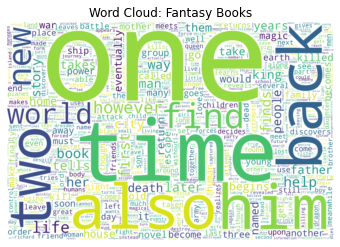

In [37]:
from wordcloud import WordCloud

# for Fantasy Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_fantasy_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Fantasy Books')
plt.show()

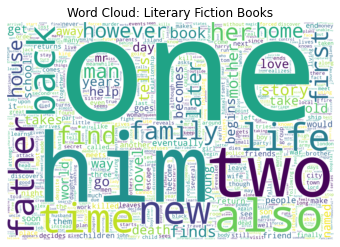

In [38]:
# for Literary Fiction Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_lit_fic_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Literary Fiction Books')
plt.show()

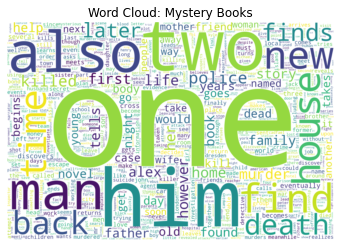

In [39]:
# for Mystery Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_mystery_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Mystery Books')
plt.show()

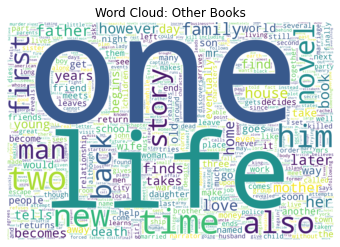

In [40]:
# for Other Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_other_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Other Books')
plt.show()

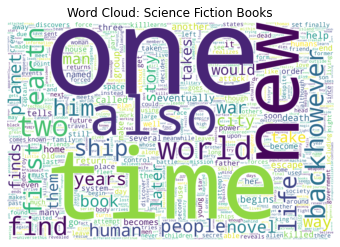

In [41]:
# for Science Fiction Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_sci_fi_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Science Fiction Books')
plt.show()

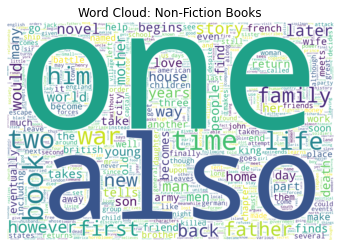

In [42]:
# for Non-Fiction Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_non_fic_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Non-Fiction Books')
plt.show()

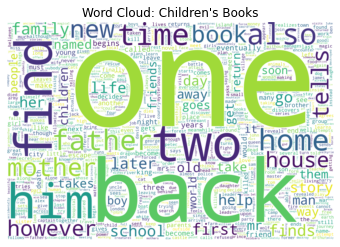

In [44]:
# for Children's Books
wordcloud = WordCloud(width = 3000, height=2000, max_words=1000, relative_scaling=1, background_color='white').generate_from_frequencies(freq_list_child_wc)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud: Children\'s Books')
plt.show()

### 1.4 Neural Networks
- Build Dataset classes and vocabularies
- Simple RNN

#### 1.4.1 Build Dataset classes and vocabularies

In [45]:
#import statements
import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [46]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [47]:
# Using the Vocabulary Class from https://www.kdnuggets.com/2019/11/create-vocabulary-nlp-tasks-python.html

class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {self.PAD_token: "PAD", self.SOS_token: "SOS", self.EOS_token: "EOS"}
        self.num_words = 3
        self.num_sentences = 0
        self.longest_sentence = 0
    
    def __len__(self):
      return self.num_words

    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence.split(' '):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word.get(index)

    def to_index(self, word):
        return self.word2index.get(word)

In [48]:
# Create Class - based off of Modern Practical Deep Learning (Raff's Class)
class BooksDataset(Dataset):
    
    def __init__(self, reviews_dict, alphabet):
        
        self.data = reviews_dict
        self.labels = [x for x in reviews_dict.keys()]
        self.alphabet = alphabet
        
    def __len__(self):
        return sum([len(x) for x in self.data.values()])
    
    # Return item from the dataset
    def __getitem__(self, idx):
        label = 0
        while idx >= len(self.data[self.labels[label]]):
            idx -= len(self.data[self.labels[label]])
            label += 1
        name = self.data[self.labels[label]][idx]
        
        
        
        label_vec = torch.zeros((1), dtype=torch.long)
        label_vec[0] = label
        
        return self.sentence2InputVec(name), label
    
    def sentence2InputVec(self, sentence):
      T = len(sentence.split(' '))
      sent_vec = torch.zeros((T), dtype=torch.long)
      for pos in range(T):
        if self.alphabet.to_index(sentence.split(' ')[pos]) is None:
          print(sentence.split(' '))
          print(pos)
          print(sentence.split(' ')[pos])
        sent_vec[pos] = self.alphabet.to_index(sentence.split(' ')[pos])
            
      return sent_vec


In [49]:
# Create Vocabulary for Genres
vocab_list_g = Vocabulary("Vocab for Genres")

In [50]:
# Add all of the words to the Vocabulary
for i, row in summary_data.iterrows():
    summary = row['summary']
    vocab_list_g.add_sentence(summary)

In [51]:
# Test to make sure vocabulary works
sent_tkns = []
sent_idxs = []

for i, row in summary_data.iterrows():
  for word in row['summary'].split(' '):
    sent_tkns.append(word)
    sent_idxs.append(vocab_list_g.to_index(word))

print(sent_tkns[:10])
print(sent_idxs[:10])

['text', 'plague', 'divided', 'five', 'parts', 'town', 'oran', 'thousands', 'rats', 'initially']
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [52]:
# Put everything in a list with the format: [[summary_1, q_group_1],[summary_2, q_group_2], ... ,[summary_n, q_group_n]]

g_label = []
for i,row in summary_data.iterrows():
  g_label.append([row['summary'],row['genre']])

# Check to see if it worked
for i in range(5):
  print(g_label[i])

['text plague divided five parts town oran thousands rats initially unnoticed populace begin die streets hysteria develops soon afterward causing local newspapers report incident authorities responding public pressure order collection cremation rats unaware collection catalyst spread bubonic plague main character dr bernard rieux lives comfortably apartment building strangely buildings concierge m michel confidante dies fever dr rieux consults colleague castel illness come conclusion plague sweeping town approach fellow doctors town authorities theory eventually dismissed basis one death however deaths quickly ensue becomes apparent epidemic authorities including prefect m othon slow accept situation serious quibble appropriate action take official notices enacting control measures posted language used optimistic downplays seriousness situation special ward opened hospital 80 beds filled within three days death toll begins rise desperate measures taken homes quarantined corpses burials

In [53]:
# Convert all the words to the index: ["This is a sentence."]->[8,19,20,25]

sent_idx_test_all = []

for i in range(len(g_label)):
  sent_tkns = []
  sent_idxs = []
  for word in g_label[i][0].split(' '):
    sent_tkns.append(word)
    sent_idxs.append(vocab_list_g.to_index(word))
  sent_idx_test_all.append(tuple([torch.FloatTensor(sent_idxs),g_label[i][1]]))


In [54]:
# Testing words to index
sent_idx_test_all[0]

(tensor([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
          15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
          27.,  28.,  29.,  30.,  31.,  32.,  33.,  11.,  34.,  32.,  35.,  36.,
          37.,   4.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
          48.,  49.,  50.,  51.,  52.,  53.,  54.,  40.,  42.,  55.,  56.,  57.,
          58.,  59.,  60.,   4.,  61.,   8.,  62.,  63.,  64.,   8.,  27.,  65.,
          66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
          27.,  78.,  79.,  50.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
          88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
          83., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,  70.,
         110., 111., 112., 113.,  93., 114., 115., 116., 117., 118., 119., 120.,
         121.,   4., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
         132., 133., 134.,  

In [55]:
# Pulled code from: https://datascience.stackexchange.com/questions/32328/export-pandas-to-dictionary-by-combining-multiple-row-values
g_dict = {}
for i in summary_data['genre'].unique():
    g_dict[i] = [summary_data['summary'][j] for j in summary_data[summary_data['genre']==i].index]

In [56]:
# check to see the genres are pulled correctly
g_dict.keys()

dict_keys(['Literary Fiction', 'Mystery', 'Science Fiction', 'Non-Fiction', 'Other', 'Fantasy', "Children's"])

In [59]:
# view all the summaries in the "Literary Fiction" category
g_dict['Literary Fiction']

['text plague divided five parts town oran thousands rats initially unnoticed populace begin die streets hysteria develops soon afterward causing local newspapers report incident authorities responding public pressure order collection cremation rats unaware collection catalyst spread bubonic plague main character dr bernard rieux lives comfortably apartment building strangely buildings concierge m michel confidante dies fever dr rieux consults colleague castel illness come conclusion plague sweeping town approach fellow doctors town authorities theory eventually dismissed basis one death however deaths quickly ensue becomes apparent epidemic authorities including prefect m othon slow accept situation serious quibble appropriate action take official notices enacting control measures posted language used optimistic downplays seriousness situation special ward opened hospital 80 beds filled within three days death toll begins rise desperate measures taken homes quarantined corpses burials

In [60]:
# Create dataset based off of Books Class
dataset_genres = BooksDataset(g_dict, vocab_list_g)

#### 1.4.2 Build Simple RNN

In [61]:
#define the class LastTimeStep (taken from Raff's Class)
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tuple (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]

        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [62]:
train_size_g = int(len(dataset_genres)*0.8)
test_size_g = len(dataset_genres)-train_size_g

train_data_g, test_data_g = torch.utils.data.random_split(dataset_genres, [train_size_g, test_size_g])


train_loader_genres = DataLoader(train_data_g, batch_size=1, shuffle=True)
test_loader_genres = DataLoader(test_data_g, batch_size=1, shuffle=False)

In [65]:
#taken from mpdl.py - Raff's Class
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * batch_size

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [64]:
print("Num classes in genre:", summary_data['genre'].nunique())
print("Length of genres vocab:", len(vocab_list_g))

Num classes in genre: 7
Length of genres vocab: 113904


In [66]:
def simple_rnn_model(D = 32, batch_size = 113904, hidden_nodes = 64):
  model = nn.Sequential(
    nn.Embedding(batch_size, D), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes, 7), #(B, D) -> (B, classes)
  ) 
  return model

In [67]:
#simple RNN for genres

loss_func = nn.CrossEntropyLoss()

simple_rnn_results_genres = train_simple_network(simple_rnn_model(), loss_func, 
                                                  train_loader_genres, 
                                                  val_loader=test_loader_genres, 
                                                  score_funcs={'Accuracy': accuracy_score}, 
                                                  device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/18133 [00:00<?, ?it/s]

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

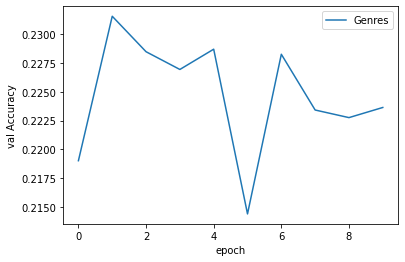

In [68]:
import seaborn as sns

sns.lineplot(x='epoch', y='val Accuracy', data=simple_rnn_results_genres, label='Genres')

In [69]:
simple_rnn_results_genres

epoch   total time    train loss     val loss  train Accuracy  val Accuracy
0      0   297.154491  34085.080046  8467.368320        0.220978      0.219012
1      1   594.934704  33715.642038  8463.209093        0.231677      0.231584
2      2   892.374409  33642.693505  8466.304712        0.237082      0.228496
3      3  1191.292495  33599.720391  8462.119209        0.234490      0.226952
4      4  1489.534074  33564.693225  8470.221660        0.240170      0.228716
5      5  1788.821466  33528.868873  8473.336924        0.240666      0.214380
6      6  2085.040100  33490.378453  8477.887082        0.242265      0.228275
7      7  2383.448929  33462.831491  8493.082312        0.245299      0.223423
8      8  2686.251550  33425.962279  8494.896152        0.243148      0.222761
9      9  2983.665349  33395.483824  8488.671739        0.244085      0.223644


#### 1.4.3 Gated Recurrent Unit (GRU)

In [70]:
!pip install  torchtext==0.5.0
!pip install  sentencepiece
!pip install tensorflow

You should consider upgrading via the 'c:\users\ethan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ethan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\ethan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [71]:
# Code taken from DATA690 - Modern Deep Learning Class
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(42)

Store the vocab size, class size, and padding index. Need to increase the voacb size by 1 so I can add a padding value. Will store the padding as padding_idx so that can be placed at the end of the batches to make them the same length.

In [72]:
VOCAB_SIZE_G = len(vocab_list_g)
NUM_CLASS_G = summary_data['genre'].nunique()

padding_idx = VOCAB_SIZE_G
VOCAB_SIZE_G += 1

Figure out what the longest sequence is and then pad to the right of each item, making them all the same length. This allows us to stack them into a single tensor.

In [73]:
#taken from Modern Practical Deep Learning
def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch. 
    Also, re-order so that the values are returned (input, label)
    """
    texts = [z[0] for z in batch]
    labels = [z[1] for z in batch]
    
    
    max_len = max([text.size(0) for text in texts])
    
    PAD = padding_idx
    
    texts = [F.pad(text, (0,max_len-text.size(0)), value=PAD) for text in texts]
    
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
    
    return x, y

In [74]:
B = 16
embed_dim = 128
epochs = 10

In [75]:
# Genres dataset
gru_train_loader_genre = DataLoader(train_data_g, batch_size = B, shuffle=True, collate_fn=pad_batch)
gru_test_loader_genre = DataLoader(test_data_g, batch_size=B, shuffle=False, collate_fn=pad_batch)

In [76]:
#taken from mpdl.py - Modern Practical Deep Learning Class
def moveTo(obj, device):
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return obj

In [77]:
#taken from mpdl.py - Modern Practical Deep Learning Class
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            
            if isinstance(labels, torch.Tensor):
                batch_size = labels.shape[0]
            elif isinstance(inputs, torch.Tensor):
                batch_size = inputs.shape[0]
            else:
                batch_size = len(inputs)

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            try:
                results["train " + name].append( score_func(y_true, y_pred) )
            except:
                results["train " + name].append("NaN")
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if isinstance(labels, torch.Tensor):
                    batch_size = labels.shape[0]
                elif isinstance(inputs, torch.Tensor):
                    batch_size = inputs.shape[0]
                else:
                    batch_size = len(inputs)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                try:
                    results["val " + name].append( score_func(y_true, y_pred) )
                except:
                    results["val " + name].append( "NaN" )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [78]:
# Genres
gru_g = nn.Sequential(
  nn.Embedding(VOCAB_SIZE_G, embed_dim), #(B, T) -> (B, T, D)
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim*2, NUM_CLASS_G), #(B, D*2) -> (B, classes)
)

In [79]:
loss_func = nn.CrossEntropyLoss()

gru_results_g = train_network(gru_g, loss_func, gru_train_loader_genre, val_loader=gru_test_loader_genre,
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1134 [00:00<?, ?it/s]

Look at the results.

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

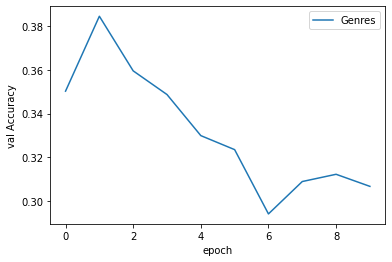

In [80]:
sns.lineplot(x='epoch', y='val Accuracy', data=gru_results_g, label='Genres')


In [81]:
gru_results_g

epoch   total time    train loss      val loss  train Accuracy  \
0      0   338.740841  32497.080044  32497.080044        0.284068   
1      1   667.067397  27828.028553  27828.028553        0.393095   
2      2   997.228207  24727.832770  24727.832770        0.453372   
3      3  1326.685856  22485.820677  22485.820677        0.495505   
4      4  1657.993438  21264.176542  21264.176542        0.508741   
5      5  1986.504727  19870.917286  19870.917286        0.520267   
6      6  2324.195520  18470.087115  18470.087115        0.536150   
7      7  2662.167430  17503.265508  17503.265508        0.539624   
8      8  2997.692481  16712.695036  16712.695036        0.540727   
9      9  3337.094668  16103.042194  16103.042194        0.550764   

   val Accuracy  
0      0.350243  
1      0.384429  
2      0.359506  
3      0.348699  
4      0.329951  
5      0.323555  
6      0.294221  
7      0.308999  
8      0.312307  
9      0.306793